In [89]:
%matplotlib inline
import pandas as pd
import dask.dataframe as dd
from dask_ml.preprocessing import DummyEncoder
import numpy as np
import altair as alt
import seaborn as sns
import math

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

import random

plt.style.use('ggplot')

# Midterm Follow-up

### Starting from your mid-term project see if you can improve your recommendations by doing the following:

- Do some exploratory data analysis on the incorrectly classified rows of data. What can you learn about this subset? How does it compare to the dataset as a whole or even look at how it compares to the set of correctly classified instances. Does this inspire any further preprocessing of the data or perhaps some additional variables that you could add? If so add them and investigate the results.
- Use either the GridSearchCV or RandomizedSearchCV class to try to find the best values for the hyperparameters for one or more of your algorithms. You should use the sklearn documenation to select some hyper parameters as well as for the details of how to use the Grid or Randomized search models.
- Finally, the ensemble learning idea could really help improve your results. That is use all three (or more) of your models and have them vote on the final classification. You can implement a simple Python class that provides a fit and predict method.

In [90]:
# 878049 rows x 9 columns
data = pd.read_csv('crimetrain.csv', parse_dates=['Dates'])
# train = pd.read_csv('crimetrain.csv')
data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


# Original Results

In [91]:
datareorder = data[['Category', 'Descript', 'Dates', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']]
datareorder.head(n=1)

,Category,Descript,Dates,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,WARRANTS,WARRANT ARREST,2015-05-13 23:53:00,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599


In [166]:
labelencoder = LabelEncoder()
for col in datareorder.columns:
    datareorder[col] = labelencoder.fit_transform(datareorder[col])
# datareorder[datareorder.Category == 20]
datareorder.head()

,Category,Descript,Dates,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,37,866,389256,6,4,0,19790,18787,23130
1,21,810,389256,6,4,0,19790,18787,23130
2,21,810,389255,6,4,0,22697,19317,32784
3,16,404,389254,6,4,11,4266,18403,32936
4,16,404,389254,6,5,11,1843,13848,21892


In [93]:
from sklearn.naive_bayes import GaussianNB
model_naive = GaussianNB()

from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier() # max_features="auto"

from sklearn.ensemble import RandomForestClassifier
model_forest = RandomForestClassifier() # max_features="auto"

In [94]:
X = datareorder.iloc[:, 1:] 
y = datareorder.iloc[:, 0]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [96]:
# GuassianNb
model_naive.fit(X_train, y_train)
nb_pred = model_naive.predict(X_test)

# Decision Tree
model_tree.fit(X_train, y_train)
tree_pred = model_tree.predict(X_test)

# Random Forest
model_forest.fit(X_train, y_train)
forest_pred = model_forest.predict(X_test)

### Accuracy Scores

In [97]:
print("ACCURACY SCORES")
print()
pred_names = ["GuassianNb", "Decision Tree", "Random Forest"]
predictions = [nb_pred, tree_pred, forest_pred]
for i in range(0, 3):
    print(pred_names[i] + ": " + str(accuracy_score(y_test, predictions[i])))

ACCURACY SCORES

GuassianNb: 0.43801605831103013
Decision Tree: 0.9993622231080235
Random Forest: 0.8871248789932237


In [98]:
len(forest_pred)

175610

### Confusion Matrices

In [99]:
print("CONFUSSION MATRICES")
print()
pred_names = ["GuassianNb", "Decision Tree", "Random Forest"]
predictions = [nb_pred, tree_pred, forest_pred]
for i in range(0, 3):
    print(pred_names[i] + ":") 
    print(str(confusion_matrix(y_test, predictions[i])))
    print()

CONFUSSION MATRICES

GuassianNb:
[[    0   124     0 ...     0     0     0]
 [    0  2138     0 ...  2432   307     0]
 [    0     1     0 ...     0     0     0]
 ...
 [    0     6     0 ... 10143    62     0]
 [    0     6     0 ...   247  2841     0]
 [    0    75     0 ...    24    13     0]]

Decision Tree:
[[  282     0     0 ...     0     0     0]
 [    0 15353     0 ...     0     0     2]
 [    0     0    71 ...     0     0     0]
 ...
 [    0     0     0 ... 10914     0     0]
 [    0     0     0 ...     0  8445     0]
 [    0     1     0 ...     0     0  1651]]

Random Forest:
[[  111    84     0 ...     0     0     0]
 [   32 14068     4 ...    51    17    23]
 [    0     3    10 ...     0     0     0]
 ...
 [    5   111     0 ... 10423     0     2]
 [    1    31     0 ...     6  8000     5]
 [    1    93     0 ...     4    34   786]]



### Classification Reports

In [100]:
print("CLASSIFICATION REPORTS")
print()

pred_names = ["GuassianNb", "Decision Tree", "Random Forest"]
predictions = [nb_pred, tree_pred, forest_pred]
sorted_names = sorted(data['Category'].unique())

for i in range(0, 3):
    print(pred_names[i] + ":") 
    print(str(classification_report(y_test, predictions[i], target_names=sorted_names)))
    print()

CLASSIFICATION REPORTS

GuassianNb:
                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       282
                    ASSAULT       0.48      0.14      0.22     15395
                 BAD CHECKS       0.00      0.00      0.00        71
                    BRIBERY       0.00      0.00      0.00        62
                   BURGLARY       0.48      0.94      0.63      7412
         DISORDERLY CONDUCT       0.00      0.00      0.00       867
DRIVING UNDER THE INFLUENCE       0.07      0.92      0.13       439
              DRUG/NARCOTIC       0.49      0.71      0.58     10836
                DRUNKENNESS       0.83      0.90      0.87       834
               EMBEZZLEMENT       1.00      0.04      0.08       214
                  EXTORTION       0.00      0.00      0.00        43
            FAMILY OFFENSES       0.00      0.00      0.00       101
     FORGERY/COUNTERFEITING       0.00      0.00      0.00      20

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                             precision    recall  f1-score   support

                      ARSON       1.00      1.00      1.00       282
                    ASSAULT       1.00      1.00      1.00     15395
                 BAD CHECKS       1.00      1.00      1.00        71
                    BRIBERY       0.98      1.00      0.99        62
                   BURGLARY       1.00      1.00      1.00      7412
         DISORDERLY CONDUCT       1.00      1.00      1.00       867
DRIVING UNDER THE INFLUENCE       1.00      1.00      1.00       439
              DRUG/NARCOTIC       1.00      1.00      1.00     10836
                DRUNKENNESS       1.00      1.00      1.00       834
               EMBEZZLEMENT       1.00      1.00      1.00       214
                  EXTORTION       1.00      1.00      1.00        43
            FAMILY OFFENSES       0.98      1.00      0.99       101
     FORGERY/COUNTERFEITING       1.00      1.00      1.00      2059
                      FRAUD      

After multiple runs of splitting the data into a training and test set and looking at the classification reports, it appears that TREA and PORNOGRAPHY/OBSCENE MAT were never classified correctly by any of the classifiers. This is most likely because there are only 6 TREA and 22 PORNOGRAPHY/OBSCENE MAT entires in the data set--not a whole of of information to train from to begin with.

In [101]:
list(y_test).count(23)

1508

# Follow-up Part 1: Data analysis of incorrectly classified rows of data
1.) Do some exploratory data analysis on the incorrectly classified rows of data. What can you learn about this subset? How does it compare to the dataset as a whole or even look at how it compares to the set of correctly classified instances. Does this inspire any further preprocessing of the data or perhaps some additional variables that you could add? If so add them and investigate the results.

## GuassianNb
- 98,691 crime categories predicted incorrectly (only 76,919 correctly! yikes)
- With a count of 8250, the most misclassified category was NON-CRIMINAL where the GuassianNb predicted it to be LARCENY/THEFT instead
- Second behind NON-CRIMINAL with a count of 5240 was OTHER OFFENSES where it was misclassificed as DRIVING UNDER THE INFLUENCE
- Third at 5230 was VANDALISM which was also misclassified as LARENCY/THEFT

In [102]:
list(y_test.values).count(34)

1498

#### key

In [103]:
key = pd.DataFrame({'category': list(data.Category), 'labelencoded': list(datareorder.Category)})
key[key.category == 'WARRANTS'].head(n=1) # change == value to find what category matched the label

,category,labelencoded
0,WARRANTS,37


In [104]:
nb = pd.DataFrame({'actual': y_test, 'predicted': nb_pred, 'random': np.random.rand(175610)}) # need random as a place 
                                                                                              # holder for groupby later
nb = nb[nb.actual != nb.predicted]
nb = nb.groupby(['actual', 'predicted']).count().reset_index().rename(columns={'random': 'count'}).sort_values(by='count', ascending=False)
nb.head(n=10)

,actual,predicted,count
142,20,16,8250
252,35,16,5256
153,21,6,5066
271,37,21,4968
4,1,4,4883
240,32,36,4787
154,21,7,4348
156,21,16,4173
135,19,16,3224
9,1,20,3008


### Top 5 misclassified categories for GuassianNB

In [105]:
nb_results = pd.DataFrame({'actual_nb': ['NON-CRIMINAL', 'OTHER OFFENSES', 'VANDALISM', 'ASSAULT', 'WARRANTS'], 'predicted_nb': ['LARENCY/THEFT', 'NON-CRIMINAL', 'LARENCY/THEFT', 'BURGLARY', 'OTHER OFFENSES'], 'count_nb': [8250, 5240, 5230, 5101, 4936]})
nb_results = nb_results[['actual_nb', 'predicted_nb', 'count_nb']]
nb_results

,actual_nb,predicted_nb,count_nb
0,NON-CRIMINAL,LARENCY/THEFT,8250
1,OTHER OFFENSES,NON-CRIMINAL,5240
2,VANDALISM,LARENCY/THEFT,5230
3,ASSAULT,BURGLARY,5101
4,WARRANTS,OTHER OFFENSES,4936


## Decision Tree
- 23,531 out of 175,610  cases misclassified

In [106]:
decT = pd.DataFrame({'actual': y_test, 'predicted': tree_pred, 'random': np.random.rand(175610)}) # need random as a place 
                                                                                              # holder for groupby later
decT = decT[decT.actual != decT.predicted]
decT = decT.groupby(['actual', 'predicted']).count().reset_index().rename(columns={'random': 'count'}).sort_values(by='count', ascending=False)
decT.head()

,actual,predicted,count
0,1,15,36
7,15,1,21
1,1,27,4
26,37,13,3
23,28,13,3


### Top 5 misclassified categories for Decision Tree

In [107]:
decT_results = pd.DataFrame({'actual_decT': ['OTHER OFFENSES', 'NON-CRIMINAL', 'OTHER OFFENSES', 'ASSAULT', 'OTHER OFFENSES'], 'predicted_decT': ['NON-CRIMINAL', 'OTHER OFFENSES', 'ASSAULT', 'NON-CRIMINAL', 'VANDALISM'], 'count_decT': [652, 579, 403, 399, 392]})
decT_results = decT_results[['actual_decT', 'predicted_decT', 'count_decT']]
decT_results

,actual_decT,predicted_decT,count_decT
0,OTHER OFFENSES,NON-CRIMINAL,652
1,NON-CRIMINAL,OTHER OFFENSES,579
2,OTHER OFFENSES,ASSAULT,403
3,ASSAULT,NON-CRIMINAL,399
4,OTHER OFFENSES,VANDALISM,392


## Random Forest
- 16,513 out of 175,610  cases misclassified

In [108]:
forest = pd.DataFrame({'actual': y_test, 'predicted': forest_pred, 'random': np.random.rand(175610)}) # need random as a place 
                                                                                              # holder for groupby later
forest = forest[forest.actual != forest.predicted]
forest = forest.groupby(['actual', 'predicted']).count().reset_index().rename(columns={'random': 'count'}).sort_values(by='count', ascending=False)
forest.head()

,actual,predicted,count
428,21,20,479
424,21,16,475
410,21,1,471
416,21,7,434
378,20,1,384


### Top 5 misclassified categories for Random Forest

In [109]:
forest_results = pd.DataFrame({'actual_forest': ['OTHER OFFENSES', 'OTHER OFFENSES', 'OTHER OFFENSES', 'NON-CRIMINAL', 'ASSAULT'], 'predicted_forest': ['ASSAULT', 'NON-CRIMINAL', 'DRUG/NARCOTIC', 'OTHER OFFENSES', 'OTHER OFFENSES'], 'count_forest': [652, 579, 403, 399, 392]})
forest_results = forest_results[['actual_forest', 'predicted_forest', 'count_forest']]
forest_results

,actual_forest,predicted_forest,count_forest
0,OTHER OFFENSES,ASSAULT,652
1,OTHER OFFENSES,NON-CRIMINAL,579
2,OTHER OFFENSES,DRUG/NARCOTIC,403
3,NON-CRIMINAL,OTHER OFFENSES,399
4,ASSAULT,OTHER OFFENSES,392


OTHER OFFENSES wrongly predicted as NON-CRIMINAL was in the top three misclassified categories for all three classifiers, vice versa, as well as ASSAULT also being misclassified as either OTHER OFFENSES or NON-CRIMINAL. Because GuassianNB did significantly worse than the Decision Tree and Random Forest classifiers, we will just look at these two classifiers from now on and see what we can do to improve results by looking deeper into the OTHER OFFENSES and NON-CRIMINAL categories.

## A Deeper Look into OTHER OFFENSES vs NON-CRIMINAL

### Maybe Descript for both OTHER OFFENSES and NON-CRIMINAL Categories is relatively the same for the top crimes which is why the classifier is having a hard time distinguishing betweeen the two. 

In [110]:
print("OTHER OFFENSES COUNT: ", len(data[data.Category == 'OTHER OFFENSES']))
print("NON-CRIMINAL COUNT: ", len(data[data.Category == 'NON-CRIMINAL']))

OTHER OFFENSES COUNT:  126182
NON-CRIMINAL COUNT:  92304


In [111]:
ood = data[data.Category == 'OTHER OFFENSES']
ood.groupby(['Descript']).count().reset_index().sort_values(by='Dates', ascending=False).head()

,Descript,Dates,Category,DayOfWeek,PdDistrict,Resolution,Address,X,Y
25,"DRIVERS LICENSE, SUSPENDED OR REVOKED",26839,26839,26839,26839,26839,26839,26839,26839
148,TRAFFIC VIOLATION,16471,16471,16471,16471,16471,16471,16471,16471
123,RESISTING ARREST,8983,8983,8983,8983,8983,8983,8983,8983
86,MISCELLANEOUS INVESTIGATION,8389,8389,8389,8389,8389,8389,8389,8389
116,PROBATION VIOLATION,8016,8016,8016,8016,8016,8016,8016,8016


In [112]:
ncd = data[data.Category == 'NON-CRIMINAL']
ncd.groupby(['Descript']).count().reset_index().sort_values(by='Dates', ascending=False).head()

,Descript,Dates,Category,DayOfWeek,PdDistrict,Resolution,Address,X,Y
27,LOST PROPERTY,31729,31729,31729,31729,31729,31729,31729,31729
6,"AIDED CASE, MENTAL DISTURBED",21497,21497,21497,21497,21497,21497,21497,21497
22,FOUND PROPERTY,12146,12146,12146,12146,12146,12146,12146,12146
2,AIDED CASE,5419,5419,5419,5419,5419,5419,5419,5419
15,"DEATH REPORT, CAUSE UNKNOWN",4207,4207,4207,4207,4207,4207,4207,4207


### Takeaways
- Descript, the highest correlation column with Category, does not seem consistent across OTHER OFFENSES and NON-CRIMINAL
- Descript is possibly not what is causing the misclassificaition of OTHER OFFENSES to be NON-CRIMINAL and vice versa

### OTHER OFFENSES most likely has a greater number of unique Descript values than other Categories, making it harder to classify, let's look into this.

In [113]:
ct = pd.crosstab(data['Category'], data['Descript']).reset_index()
ct.head()

Descript,Category,ABANDONMENT OF CHILD,ABORTION,"ACCESS CARD INFORMATION, PUBLICATION OF","ACCESS CARD INFORMATION, THEFT OF",ACCIDENTAL BURNS,ACCIDENTAL SHOOTING,ACTS AGAINST PUBLIC TRANSIT,ADVERTISING DISTRIBUTORS PERMIT VIOLATION,"AEROSOL CONTAINER; SALE, PURCHASE OR POSSESSION OF",...,"WEAPON, DEADLY, CARRYING WITH INTENT TO COMMIT ASSAULT","WEAPON, DEADLY, EXHIBITING TO RESIST ARREST","WEAPON, POSSESS OR BRING OTHER ON SCHOOL GROUNDS","WEAPON, POSSESSING IN PUBLIC BUILDING OR OPEN MEETING","WEAPON, TAKING OR ATTEMPTING TO TAKE FROM PEACE OFFICER",WEAPONS POSSESSION BY JUVENILE SUSPECT,WEARING MASK OR DISGUISE FOR UNLAWFUL PURPOSE,WEARING THE APPAREL OF OPPOSITE SEX TO DECEIVE,WILLFUL CRUELTY TO CHILD,YOUTH COURT
0,ARSON,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ASSAULT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,114,0
2,BAD CHECKS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BRIBERY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,BURGLARY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
# crosstab of Category and Descript
ct = pd.crosstab(data['Category'], data['Descript']).reset_index()

# for loop to iterate through rows and columns
total = {}
for index, row in ct.iterrows():
    category = ""
    count = 0
    for col in row:
        if isinstance(col, str):
            category = col
        elif col != 0:
            count += 1
    total[category] = count

In [115]:
ctcd = pd.Series(total, name='count_of_unique_descripts').reset_index().rename(columns={'index': 'category'}).sort_values(by='count_of_unique_descripts', ascending=False)
ctcd.head()

,category,count_of_unique_descripts
21,OTHER OFFENSES,169
25,ROBBERY,72
7,DRUG/NARCOTIC,69
1,ASSAULT,63
16,LARCENY/THEFT,62


### Takeaways
It is evident that the number of unique descriptions for OTHER OFFENSES is significantly higher than the rest of the 38 categories. Coming in at 162 unique descriptions, this is more than ROBBERY, the second runner up, checking in at 72 unique descriptions. Because Descript is a great indictor of Category, having a large number of Descripts has caused the classifiers to be thrown off and not predict OTHER OFFENSES as well as other Categories. 

### If we take out OTHER OFFENSES, how much will our results improve?

In [116]:
# getting rid of OTHER OFFENSES
dropOF = data[data.Category != 'OTHER OFFENSES'] # 126,182 rows were dropped
# reordering columns
dropOFReorder = dropOF[['Category', 'Descript', 'Dates', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']]
dropOFReorderAgain = dropOF[['Category', 'Descript', 'Dates', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']]
# dropOFReorder.head()

In [117]:
labelencoder = LabelEncoder()
for col in dropOFReorderAgain.columns:
    dropOFReorderAgain[col] = labelencoder.fit_transform(dropOFReorderAgain[col])
dropOFReorderAgain.head()

,Category,Descript,Dates,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,36,700,345356,6,4,0,19468,18412,22625
3,16,349,345355,6,4,11,4245,18034,32343
4,16,349,345355,6,5,11,1836,13533,21404
5,16,351,345355,6,2,11,1500,28643,1316
6,35,600,345355,6,2,11,13225,19386,4638


In [118]:
Xof = dropOFReorderAgain.iloc[:, 1:] 
yof = dropOFReorderAgain.iloc[:, 0]

Xof_train, Xof_test, yof_train, yof_test = train_test_split(Xof, yof, test_size=0.2)

# GuassianNB
model_naive.fit(Xof_train, yof_train)
nb_predof = model_naive.predict(Xof_test)

# Decision Tree
model_tree.fit(Xof_train, yof_train)
tree_predof = model_tree.predict(Xof_test)

# Random Forest
model_forest.fit(Xof_train, yof_train)
forest_predof = model_forest.predict(Xof_test)

In [119]:
print("ACCURACY SCORES")
print()
pred_names = ["GuassianNb", "Decision Tree", "Random Forest"]
predictions = [nb_predof, tree_predof, forest_predof]
for i in range(0, 3):
    print(pred_names[i] + ": " + str(accuracy_score(yof_test, predictions[i])))

ACCURACY SCORES

GuassianNb: 0.5057722744623405
Decision Tree: 0.9994613430513254
Random Forest: 0.9085147698405309


### Takeaways
- As expected, all the classifiers did significantly better without OTHER OFFENSES to account for

## That was fun, but let's do some data exploration of the misclassified data to see what's really going on

In [167]:
# le = {}
# for i in range(len(data)):
#     le[i] = LabelEncoder()
#     data.iloc[:,i] = le[i].fit_transform(data.iloc[:,i])
# do stuff
# for i in range(len(misclassified)):
#     X.iloc[:,i] = le[i].inverse_transform(X.iloc[:,i])

In [169]:
misclassified = X_test[list(y_test) != forest_pred]
correct = X_test[list(y_test) == forest_pred]
# x = list(labelencoder.inverse_transform(forest_pred)) 
# x
# y = labelencoder.inverse_transform(list(y_test))
# for col in datareorder.columns:
#     datareorder[col] = labelencoder.inverse_transform(datareorder[col]).any()
# datareorder.head()


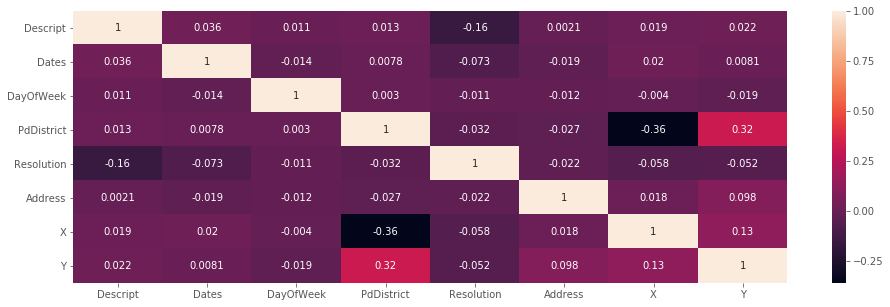

In [168]:
plt.figure(figsize = (16,5))
ax = sns.heatmap(misclassified.corr(), annot=True)

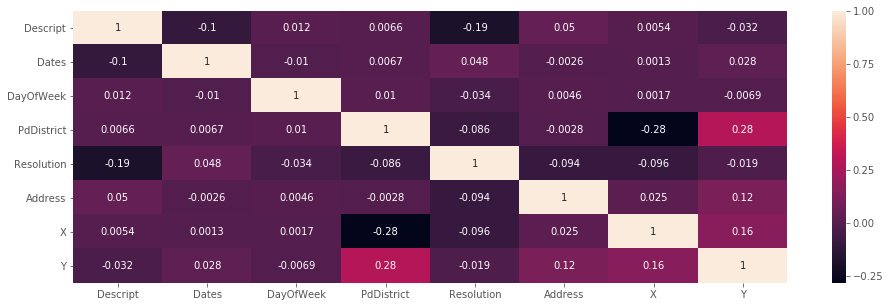

In [170]:
plt.figure(figsize = (16,5))
ax = sns.heatmap(correct.corr(), annot=True)

# Follow-up Part 2: GridSearchCV

Use either the GridSearchCV or RandomizedSearchCV class to try to find the best values for the hyperparameters for one or more of your algorithms. You should use the sklearn documenation to select some hyper parameters as well as for the details of how to use the Grid or Randomized search models.
- In most cases, the best way to determine optimal values for hyperparameters is through a grid search over possible parameter values, using cross validation to evaluate the performance of the model on your data at each value
    - (Exhaustive search over specified parameter values for an estimator.)
- Hyperparameter optimization finds a tuple of hyperparameters that yields an optimal model which minimizes a predefined loss function on given independent data. The objective function takes a tuple of hyperparameters and returns the associated loss. Cross-validation is often used to estimate this generalization performance.


####  *Random forest, Logistic Regression, and SVM were all taking more than two hours to run so unfortunely I was only able to hyper-tune the Decision Tree Classifier.*

## Decision Tree

### Parameters to try out
- max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- max_features: The number of features to consider when looking for the best split:
- max_leaf_nodes: Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
- splitter: 

In [37]:
%%time

parameters = {'max_depth': [None, 15, 20, 30], 'max_features': [None, 4, "sqrt", "log2"], 'max_leaf_nodes': [None, 10, 50, 100, 120, 150, 200, 300, 500], 'splitter': ['random', 'best']}
model_treeGrid = GridSearchCV(DecisionTreeClassifier(), parameters)
model_treeGrid.fit(X_train, y_train)

CPU times: user 17min 28s, sys: 1min 18s, total: 18min 46s
Wall time: 18min 46s


In [38]:
model_treeGrid.best_params_

{'max_depth': 30,
 'max_features': None,
 'max_leaf_nodes': None,
 'splitter': 'best'}

In [39]:
treeGrid_pred = model_treeGrid.predict(X_test)

In [40]:
accuracy_score(y_test, treeGrid_pred)

0.999424861909914

In [41]:
confusion_matrix(y_test, treeGrid_pred)

array([[  317,     0,     0, ...,     0,     0,     0],
       [    0, 15357,     0, ...,     0,     0,     0],
       [    0,     0,    96, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ..., 10743,     0,     0],
       [    0,     0,     0, ...,     0,  8373,     0],
       [    0,     0,     0, ...,     0,     0,  1684]])

In [42]:
print(classification_report(y_test, treeGrid_pred, target_names=sorted_names))

                             precision    recall  f1-score   support

                      ARSON       1.00      1.00      1.00       317
                    ASSAULT       1.00      1.00      1.00     15397
                 BAD CHECKS       1.00      1.00      1.00        96
                    BRIBERY       1.00      1.00      1.00        61
                   BURGLARY       1.00      1.00      1.00      7405
         DISORDERLY CONDUCT       1.00      1.00      1.00       831
DRIVING UNDER THE INFLUENCE       1.00      1.00      1.00       447
              DRUG/NARCOTIC       1.00      1.00      1.00     10779
                DRUNKENNESS       1.00      1.00      1.00       847
               EMBEZZLEMENT       1.00      1.00      1.00       246
                  EXTORTION       1.00      1.00      1.00        53
            FAMILY OFFENSES       1.00      1.00      1.00        94
     FORGERY/COUNTERFEITING       1.00      1.00      1.00      2131
                      FRAUD      

### Takeaways
- The best parameters were {'max_depth': 30, 'max_features': None, 'max_leaf_nodes': None}
- After hyper-tuning, the accuracy score was 99% -- a significant improvement from the original 90% 

## Follow-up Part 3: Ensemble Learning

In [47]:
%%time

estimators = [('NB', model_naive), ('DT', model_treeGrid), ('RF', model_forest)]
votingClass = VotingClassifier(estimators)
votingClass.fit(X_train, y_train)
pred_ens = votingClass.predict(X_test)

KeyboardInterrupt: 

In [ ]:
for clf, label in zip([model_naive, model_treeGrid, model_forest, votingClass], ['Naive Bayes','Decision Tree', 'Random Forest', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [74]:
accuracy_score(y_test, pred_ens)

0.8138773418370252

In [75]:
confusion_matrix(y_test, pred_ens)

array([[  169,    77,     0, ...,     0,     0,     0],
       [   56, 13652,     6, ...,   217,     2,     3],
       [    0,     2,    16, ...,     0,     0,     0],
       ...,
       [    9,   123,     0, ..., 10233,     0,     2],
       [    0,    79,     0, ...,    26,  7366,     1],
       [    3,   154,     3, ...,     2,    16,   549]])

In [87]:
print(classification_report(y_test, pred_ens, target_names=sorted_names))

                             precision    recall  f1-score   support

                      ARSON       0.38      0.43      0.40       280
                    ASSAULT       0.73      0.90      0.81     15498
                 BAD CHECKS       0.15      0.20      0.17        75
                    BRIBERY       0.21      0.13      0.16        55
                   BURGLARY       0.84      0.99      0.91      7427
         DISORDERLY CONDUCT       0.50      0.51      0.51       929
DRIVING UNDER THE INFLUENCE       0.32      0.87      0.47       447
              DRUG/NARCOTIC       0.73      0.93      0.82     10676
                DRUNKENNESS       0.59      0.78      0.67       872
               EMBEZZLEMENT       0.33      0.32      0.32       236
                  EXTORTION       0.11      0.08      0.09        50
            FAMILY OFFENSES       0.25      0.17      0.20       101
     FORGERY/COUNTERFEITING       0.60      0.61      0.61      2125
                      FRAUD      

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
